<a href="https://colab.research.google.com/github/SLVmain/NLP/blob/Les_04/HW_04_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Урок 4. Тематическое моделирование. EM-алгоритм
Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет (источник): положительные, отрицательные.

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

## Закачка данных

In [3]:
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

In [10]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 300), desc='Pages'):
    time.sleep(0.5)
    #print(main_url.format(page=page))
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    #print(soup.findAll('a', {'class':'appeal-title-link'}))
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/299 [00:00<?, ?it/s]

In [12]:
len(urls)

1495

In [13]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

questions = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    questions.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/1495 [00:00<?, ?it/s]

In [14]:
## посмотрим, что скачалось
N = 2
print('Q:', questions[N])
print()
print('A:', answers[N])

Q: Добрый день.
Купила в магазине техники электросамокат,попробовать как он ездит,в магазине не разрешили,попросила продавца рассказать про товар,она сказала,что она о нем ничего не знает,колеса..руль...газ..тормоз,сигнал горит,в течение двух недель можете вернуть - это все что было сказано.Попробовала дома его,а у этой модели практически нет амортизации и жесткий ход колеса и сложить самой его очень трудно.Приехала в магазин через 4 дня,где мне отказали его взять,сославшись на то,что этот товар с электродвигателем и входит в перечень товаров,которые нельзя вернуть,а только обменять на аналогичный,но в магазине не было такой модели с похожими характеристиками.Мне посоветовали написать претензию и вернули товар обратно.Правомерны ли действия магазина?и если не правомерны,то можно ссылку на закон?

A: Добрый день! Повторно, согласно ст.25 Закона о защите прав потребителей,от 07.02.1992 № 2300-1,  Потребитель вправе обменять непродовольственный товар надлежащего качества на аналогичный то

In [18]:
len(questions), len(answers)

(1495, 1495)

In [22]:
import pickle
path = 'C:\\Users\\SR_Ad\\NLP\\HW04\\'

with open(path + "questions_file1k.pkl", 'wb') as f:
  pickle.dump(questions, f)

In [24]:
import pickle
path =  'C:\\Users\\SR_Ad\\NLP\\HW04\\'

In [25]:
with open(path + "questions_file1k.pkl", 'rb') as f:
     questions1 = pickle.load(f)

In [26]:
len(questions1)

1495

In [27]:
questions1[2]

'Добрый день.\r\nКупила в магазине техники электросамокат,попробовать как он ездит,в магазине не разрешили,попросила продавца рассказать про товар,она сказала,что она о нем ничего не знает,колеса..руль...газ..тормоз,сигнал горит,в течение двух недель можете вернуть - это все что было сказано.Попробовала дома его,а у этой модели практически нет амортизации и жесткий ход колеса и сложить самой его очень трудно.Приехала в магазин через 4 дня,где мне отказали его взять,сославшись на то,что этот товар с электродвигателем и входит в перечень товаров,которые нельзя вернуть,а только обменять на аналогичный,но в магазине не было такой модели с похожими характеристиками.Мне посоветовали написать претензию и вернули товар обратно.Правомерны ли действия магазина?и если не правомерны,то можно ссылку на закон?'

### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [29]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
#from pymystem3 import Mystem

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SR_Ad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [32]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')
morestopwords = ['это', 'который', "каждый"]
stopwords_list += morestopwords

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [33]:
morestopwords = ['это', 'который', 'каждый']
stopwords_list += morestopwords

In [34]:
questions1[1]

'Добрый день! помогите пожалуйста разобраться в ситуации. в приложении Вайлдберриз я заказала игрушку для сына 16 мая этого года. срок доставки стоял 19-20 мая. однако в этот срок игрушку не доставили, более того, пишут каждый раз что товар задерживается и ставят новые сроки. что мне делать? могу я как-то уже отказаться от неё?'

In [35]:
print(preprocess(questions1[1]))

['добрый', 'день', 'помочь', 'пожалуйста', 'разобраться', 'ситуация', 'приложение', 'вайлдберриз', 'заказать', 'игрушка', 'сын', 'май', 'год', 'срок', 'доставка', 'стоять', 'май', 'однако', 'срок', 'игрушка', 'доставить', 'писать', 'товар', 'задерживаться', 'ставить', 'новый', 'срок', 'делать', 'мочь', 'отказаться']


In [36]:
preprocessed_q = list(tqdm(map(preprocess, questions1), total=len(questions1)))

  0%|          | 0/1495 [00:00<?, ?it/s]

## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [ ]:
!pip install -U gensim

In [39]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [43]:
dictionary = corpora.Dictionary(preprocessed_q)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save(path+'question.dict')

In [48]:
dictionary.cfs[dictionary.token2id['заказ']], dictionary.dfs[dictionary.token2id['заказ']]

(551, 204)

Векторизуем документы:

In [49]:
corpus = [dictionary.doc2bow(text) for text in preprocessed_q]
corpora.MmCorpus.serialize(path+'rosnadzor.model', corpus) 

In [50]:
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 4), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 6), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 7), (41, 1), (42, 2), (43, 1), (44, 4), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1)]]


In [51]:
%time 
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

Wall time: 0 ns


In [52]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(14,
  '0.070*"номер" + 0.066*"машина" + 0.056*"решить" + 0.048*"проблема" + 0.041*"стать" + 0.038*"компания" + 0.031*"оплата" + 0.027*"жилец" + 0.027*"оплатить" + 0.027*"управлять"'),
 (7,
  '0.022*"компания" + 0.021*"ответ" + 0.017*"документ" + 0.016*"год" + 0.014*"получить" + 0.014*"всё" + 0.013*"ооо" + 0.013*"вопрос" + 0.013*"дать" + 0.013*"работа"'),
 (5,
  '0.048*"организация" + 0.046*"проверка" + 0.036*"пользоваться" + 0.036*"технический" + 0.036*"дата" + 0.030*"провести" + 0.029*"отношение" + 0.029*"область" + 0.029*"получать" + 0.028*"помощь"'),
 (2,
  '0.057*"размер" + 0.039*"стоимость" + 0.036*"товар" + 0.030*"приобрести" + 0.029*"либо" + 0.026*"составить" + 0.024*"момент" + 0.023*"дать" + 0.022*"вообще" + 0.022*"качество"'),
 (11,
  '0.118*"дом" + 0.045*"вода" + 0.043*"мастер" + 0.040*"жилой" + 0.036*"площадка" + 0.032*"работа" + 0.030*"постановление" + 0.025*"маска" + 0.024*"место" + 0.023*"администрация"'),
 (6,
  '0.205*"товар" + 0.171*"магазин" + 0.064*"продавец" + 0.0

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки __pyLDAvis__. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [53]:
!pip install pyLDAvis

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=16f46fb09b51d9336fcbe05162cb02174b17d148a292e128d9f5ef169cc75666
  Stored in directory: c:\users\sr_ad\appdata\local\pip\cache\wheels\90\61\ec\9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=ce2127bfb525f6dcc7e9a2ac6a0e09c8c5c81727ca424dec4b13ac7f772d9c71
  Stored in directory: c:\users\sr_ad\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb7

In [54]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time 
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Wall time: 0 ns


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [55]:
print(lda.log_perplexity(corpus))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-10.590653532340086


In [56]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  2.5150161884325777e-05


In [57]:
coherence_model_lda = CoherenceModel(model=lda, texts=preprocessed_q, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Средняя когерентность:  0.3677605337316101


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/13 [00:00<?, ?it/s]

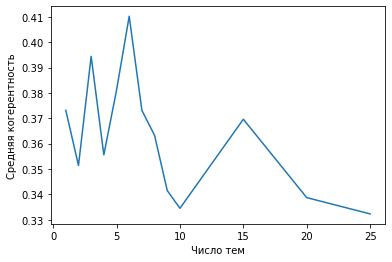

In [59]:
topics_list = [1, 2, 3, 4, 5, 6, 7 , 8, 9, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=preprocessed_q, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [65]:
lda_8 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=6, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_8, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
lda_8.show_topics(num_topics=8, num_words=10, formatted=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.094*"магазин" + 0.030*"товар" + 0.020*"рубль" + 0.017*"дать" + 0.016*"интернет" + 0.015*"составить" + 0.013*"здравствуйте" + 0.013*"продавец" + 0.012*"цена" + 0.011*"заявить"'),
 (1,
  '0.066*"товар" + 0.043*"возврат" + 0.026*"средство" + 0.025*"день" + 0.025*"магазин" + 0.024*"вернуть" + 0.022*"продавец" + 0.020*"денежный" + 0.017*"деньга" + 0.015*"приобрести"'),
 (2,
  '0.067*"ремонт" + 0.042*"новый" + 0.029*"центр" + 0.028*"квартира" + 0.028*"вода" + 0.025*"гарантийный" + 0.022*"говорить" + 0.022*"здравствуйте" + 0.021*"мочь" + 0.020*"год"'),
 (3,
  '0.047*"заказ" + 0.020*"доставка" + 0.018*"деньга" + 0.018*"оплатить" + 0.018*"сказать" + 0.015*"банк" + 0.013*"сделать" + 0.013*"карта" + 0.013*"день" + 0.013*"телефон"'),
 (4,
  '0.027*"день" + 0.021*"ответ" + 0.017*"тест" + 0.017*"личный" + 0.016*"обращение" + 0.015*"почта" + 0.014*"кабинет" + 0.013*"добрый" + 0.013*"документ" + 0.013*"дать"'),
 (5,
  '0.021*"право" + 0.016*"правило" + 0.015*"поликлиника" + 0.013*"требование

# Можно попробовать определить темы: номер 1,2  -  торговля товарами   4 качество услуг ЖКХ